## Model prediction and evaluation

- Predict snow depth by pre-trained regressor.
- Validate/compared with other data sources.

In [13]:
# option (a) locally import

import sys
import os
# Construct the path to the xsnow directory
# Adjust the number of os.path.dirname() calls based on your directory structure
xsnow_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, 'xsnow'))
# Add xsnow to sys.path
if xsnow_path not in sys.path:
    sys.path.insert(0, xsnow_path)

import xsnow

In [15]:
# option (b) experimental install
import xsnow
# reload xsnow
#from importlib import reload
#reload(xsnow)

### (1) data preparation

The data used for snow depth prediction/validation contains the following columns:
- (1) ERA5 Monthly to be downscaled: snow depth, wind_aspect_factor.
- (2) raw data calculated from DTM10, namely raw_pts: terrain parameters.
- (3) Senorge monthly snow depth.

In [16]:
# (1) ERA5 monthly data
import pandas as pd
from xsnow.goregression import ERA5

# load monthly era5
era_monthly = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\EAR5_land\monthly_data_08_22.nc'
era = ERA5(era_monthly)
# Calculate wind_aspect_factor_index
era.cal_wind_aspect_factor_yearly()


2008 1
2008 9
2009 9
2010 9
2011 9
2012 9
2013 9
2014 9
2015 9
2016 9
2017 9
2018 9
2019 9
2020 9
2021 9
2022 9


In [17]:
# (2) raw data
def get_df(df_list,crop=[6649790,6700092,49816,123488],x='E',y='N'):

    min_y,max_y,min_x,max_x = crop[0],crop[1],crop[2],crop[3]
    df_ = []
    path = r'\\hypatia.uio.no\\lh-mn-geofag-felles\\projects\\snowdepth\\zhihaol\\data\\target_area\\'
    for dem in df_list:
        df = pd.read_csv(path+dem)
        df = df[(df[y] >= min_y) & (df[y] <= max_y) & (df[x] >= min_x) & (df[x] <= max_x)].copy()
        df = df.dropna()
        df_.append(df)
    return pd.concat(df_, axis=0)

# combine multiple csv. These csv are generated from the 10m DEMs and covered the area of interest.
df_list = ['6601_4_10m_z33.csv','6600_1_10m_z33.csv','6700_2_10m_z33.csv','6700_3_10m_z33.csv','6701_3_10m_z33.csv','6600_4_10m_z33.csv']
# crop to the area of interest
new_df = get_df(df_list,crop=[6650000,6706000,41000,125000]).drop_duplicates()

In [18]:
import xarray as xr

# (3) senorge data
# List of file paths
file_paths = [r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\senorge\sd_2008.nc', 
              r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\senorge\sd_2009.nc',
              r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\senorge\sd_2020.nc']

# Load datasets
se = [xr.open_dataset(fp) for fp in file_paths]
# Concatenate along the time dimension
se_all = xr.concat(se, dim='time')
se_all = ERA5(se_all)

### (2) downscaling model prediction



In [22]:
# CASE6

from xsnow.goregression import Snow_Distributor
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', 'SettingWithCopyWarning')

case_6 = Snow_Distributor(new_df,
                          era,
                          senorge=se_all,
                          features=['E','N','h_te_best_fit','slope', 'aspect', 
                                  'planc','profc','tpi','tpi_9','tpi_27',
                                  'curvature','sde_era','wf_positive', 
                                  'wf_negative','month'],
                          regressor_list = ['sd_dtm1_abserror_250_10_qc_nve_geosegment_abs_feb.json',
                                             'sd_dtm10_abserror_250_10_qc_nve_geosegment_abs_feb.json',
                                             'sd_cop30_abserror_250_10_qc_nve_geosegment_abs_feb.json',
                                             'sd_fab_abserror_250_10_qc_nve_geosegment_abs_feb.json'],
                          )

case_6.product_time_series(dates=['20080401','20200601'],correction='qm',regression='MAD');
case_6.timeseries = case_6.mask_out_lake()

# the results is saved in the case_6.timeseries


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 1/1 [03:20<00:00, 200.06s/it]


Monthly coupling - the last date: 2008-05-01 00:00:00


100%|██████████| 1/1 [03:15<00:00, 195.70s/it]]


Monthly coupling - the last date: 2020-07-01 00:00:00


100%|██████████| 2/2 [40:28<00:00, 1214.29s/it]


### (2.1) Calibration

In [31]:
import rioxarray
import rasterio
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, r2_score

dem_path = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\nve_08_merge_m.tif' # Path to the DEM TIFF file
als = rioxarray.open_rasterio(dem_path)
test = case_6.timeseries.sel(time='2008-04-01').rename({'E':'x','N':'y'})
test.rio.set_crs(als.rio.crs)
als = als.where(als != als.rio.nodata).squeeze()
als_m = als.rio.reproject_match(test)

In [69]:
test

<xarray.Dataset>
Dimensions:            (x: 8400, y: 5600)
Coordinates:
  * x                  (x) float64 4.1e+04 4.102e+04 ... 1.25e+05 1.25e+05
  * y                  (y) float64 6.65e+06 6.65e+06 ... 6.706e+06 6.706e+06
    time               datetime64[ns] 2008-04-01
Data variables: (12/15)
    lake_mask          (y, x) bool False False False False ... False False False
    sde_se             (y, x) float64 5.513 5.524 5.535 ... 1.083 1.083 1.084
    sd_predict_fab     (y, x) float64 6.843 6.35 5.934 ... 1.489 1.548 1.49
    z                  (y, x) float64 1.414e+03 1.415e+03 ... 1.225e+03
    sd_predict_cop30   (y, x) float64 7.026 6.646 5.656 ... 1.601 1.653 1.668
    aspect             (y, x) float64 274.4 237.6 237.1 ... 226.8 222.6 213.1
    ...                 ...
    sd_predict_dtm10   (y, x) float64 7.318 6.509 5.835 ... 1.645 1.635 1.536
    sde_era            (y, x) float64 3.579 3.579 3.579 ... 1.596 1.596 1.596
    sd_predict_dtm1    (y, x) float64 5.72 5.888 5.166 ... 1.529 1.541 1.636
    sd_predict_dtm10_  (y, x) float64 9.994 9.994 9.351 2.995 ... 0.01 0.01 0.01
    sd_predict_cop30_  (y, x) float64 9.994 9.994 9.091 4.643 ... 0.01 0.01 0.01
    sd_predict_fab_    (y, x) float64 9.994 9.994 9.994 3.965 ... 0.01 0.01 0.01

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


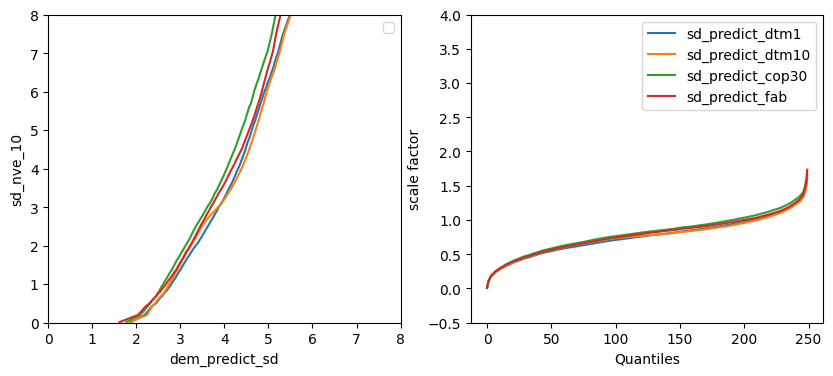

In [73]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle

def cal_quantile_scaling(case_6, i, als_m, n_range, e_range, quantile_range=np.linspace(0, 1, 250)):
    """
    Plots the scaling factor between quantiles of two datasets selected by coordinates.

    Parameters:
    - case_6: xarray Dataset for case_6.timeseries
    - als_m: xarray DataArray for als_m
    - lat_range: Tuple of (min, max) for latitude selection
    - lon_range: Tuple of (min, max) for longitude selection
    - quantile_range: Numpy array of quantiles to calculate (default is np.arange(0.1, 1.0, 0.1))
    """
    
    fill_value = -3.4028235e+38  # This is your _FillValue
    als_m = als_m.where(als_m != fill_value, np.nan)
    als_m = als_m.where(test['lake_mask']== 0)

    # Tailor datasets by coordinates (assuming latitude and longitude are the coordinates)
    case_6_sel = case_6.sel(y=slice(*n_range), x=slice(*e_range))
    als_m_sel = als_m.sel(y=slice(*n_range), x=slice(*e_range))
    
    # Calculate quantiles for both selected datasets
    # Replace 'variable_name' with the actual variable name
    quantiles_case_6 = case_6_sel[i].quantile(quantile_range, dim=['y', 'x'])
    quantiles_als_m = als_m_sel.quantile(quantile_range, dim=['y', 'x'])
    
    # Calculate scaling factors
    scaling_factors = quantiles_als_m / quantiles_case_6
    
    dq_lt1 = None
    dem_q_lt1 = None
    dq_gt1 = scaling_factors
    dem_q_gt1 = quantiles_case_6

    return {'delta_lt1': dq_lt1, 'dem_q_lt1':dem_q_lt1, 'delta_gt1': dq_gt1,'dem_q_gt1':dem_q_gt1 }

def save_qm(test, 
            als_m, 
            n,
            e,
            f_name='adjust_factor_08_case6.pkl'):

    adjust_factor = {}

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    for i in ['sd_predict_dtm1', 'sd_predict_dtm10', 'sd_predict_cop30', 'sd_predict_fab']:
        adjust_factor[i] = cal_quantile_scaling(test, i, als_m, n, e)
        ax[0].plot(adjust_factor[i]['dem_q_gt1'],adjust_factor[i]['dem_q_gt1']*adjust_factor[i]['delta_gt1'])
        ax[1].plot(adjust_factor[i]['delta_gt1'], label=f'{i}')

    ax[0].set_xlabel('dem_predict_sd')
    ax[0].set_ylabel('sd_nve_10')
    ax[0].set_xlim(0, 8)
    ax[0].set_ylim(0, 8)
    ax[0].legend()

    ax[1].set_xlabel('Quantiles')
    ax[1].set_ylabel('scale factor')
    ax[1].set_ylim(-0.5, 4)
    ax[1].legend()

    plt.show()

    # Save adjust_factor dictionary to a file
    with open(f_name, 'wb') as f:
        pickle.dump(adjust_factor, f)

save_qm(test, als_m, (6674366, 6674866), (53000, 56000), f_name='adjust_factor_08_west.pkl')
#save_qm(test, als_m, (6684456, 6684456+500), (102000, 105000), f_name='adjust_factor_08_east.pkl')


In [ ]:
# load scaling bias

with open('adjust_factor_08_case6.pkl', 'rb') as f:  # adjust_factor_08_test is from 
    adjust_factor = pickle.load(f )
    for als, factor in adjust_factor.items():
        quantile_mapping_xr(test,factor['delta_lt1'],factor['delta_gt1'],dem=als, split=0,offset=0)
        #quantile_mapping_original_xr(test,factor['delta_gt1'],factor['dem_q_gt1'],dem=als, split=0,offset=0)

In [ ]:
# save scaling bias



### (3) Evaluation of the model prediction

#### 3.1 mesoscale - Plot in chart

In [23]:
import rioxarray
import rasterio
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, r2_score

dem_path = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\nve_08_merge_m.tif' # Path to the DEM TIFF file
als = rioxarray.open_rasterio(dem_path)
test = case_6.timeseries.sel(time='2008-04-01').rename({'E':'x','N':'y'})
test.rio.set_crs(als.rio.crs)
als = als.where(als != als.rio.nodata).squeeze()
als_m = als.rio.reproject_match(test)

In [24]:
import numpy as np
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from xsnow.misc import evaluate_difference
#reload(xsnow.misc)

def extract_along_line(resampled_da1, resampled_da2, resampled_dah, resampled_das,resampled_dae):

    # Define the coordinates of the start and end points for each of the five lines
    lines = [
        ((41000, 6704000), (122100, 6705505)),
        ((41000, 6694000), (122100, 6696000)),
        ((41000, 6683500), (122100, 6685371)),
        ((41000, 6673620), (122100, 6675092)),
        ((41000, 6663300), (122100, 6664674)),
        ((41000, 6653100), (122100, 6654503)),
    ]


    # Initialize lists to store the extracted values for each line
    values_da1_list = []
    values_da2_list = []
    values_dah_list = []
    values_das_list = []
    values_dae_list = []

    x_list = []

    for line in lines:
        (x_start, y_start), (x_end, y_end) = line

        # Create a grid of coordinates along the line
        x_line = np.arange(x_start, x_end + 10, 10)
        y_line = np.arange(y_start, y_end + 10, 10)

        # Interpolate values from the resampled DataArrays using map_coordinates
        # return values from a grid in resolution 10m
        values_da1 = resampled_da1.interp(x=x_line, y=y_line, method='linear')
        values_da2 = resampled_da2.interp(x=x_line, y=y_line, method='linear')
        values_dah = resampled_dah.interp(x=x_line, y=y_line, method='nearest')
        values_das = resampled_das.interp(x=x_line, y=y_line, method='linear')
        values_dae = resampled_dae.interp(x=x_line, y=y_line, method='linear')

        # mask by da2
        values_da2 = values_da2.where(values_da1.notnull())
        values_da1 = values_da1.where(values_da2 > 0)
        #values_dah = values_dah.where(values_da2.notnull())
        values_das = values_das.where(values_da1.notnull())

        # Append the extracted values for each line to the respective lists
        values_da1_list.append(values_da1)
        values_da2_list.append(values_da2)
        values_dah_list.append(values_dah)
        values_das_list.append(values_das)
        values_dae_list.append(values_dae)

        x_list.append(x_line)

    # Now, values_da1_list and values_da2_list contain the extracted values for each of the five lines using map_coordinates interpolation.
    return values_da1_list, values_da2_list, values_dah_list, values_das_list, values_dae_list, x_list

def plot_scatter_snow_depth(values_da1_list, 
                            values_da2_list, 
                            values_dah_list, 
                            values_das_list,
                            values_dae_list,
                            x_list,
                            window_size_x=10,
                            title='snowdepth_senoreg_scatter.jpg'):
    
    # Create a figure with five subplots
    fig, axs = plt.subplots(6, 1, figsize=(15, 9))  # Adjust figsize as needed
    
    color = ["#1f77b4", # Strong blue for R1
            "#ff7f0e", # Strong orange for A1
            "#e7ba52", # Lighter orange for A2
            "#2ca02c", # Strong green for B1
            "#17becf", # Lighter blue for B2
            "#b3b3b3"  # Muted grey for R2
            ]

    data_m = {}
    data_s = {}

    # Loop through each line's extracted values and plot them as scatter plots
    for i, (values_da1, values_da2, values_dah,values_das,values_dae, x) in enumerate(zip(values_da1_list, values_da2_list, values_dah_list,values_das_list,values_dae_list,x_list)):
        ax = axs[i]
        ax.set_title('')
        ax.label_outer()
        ax.set_ylim((0,8))
        ax.set_xlim(min(x), max(x))

        da1 = values_da1.mean(dim='y',skipna=True).rolling(x=window_size_x, center=True).mean()
        da2 = values_da2.mean(dim='y',skipna=True).rolling(x=window_size_x, center=True).mean()
        das = values_das.mean(dim='y',skipna=True).rolling(x=window_size_x, center=True).mean()
        dae = values_dae.mean(dim='y',skipna=True).rolling(x=window_size_x, center=True).mean()

        # Scatter plot for DataArray z
        # add the secondaries y-axis
        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.plot(x, 
                    values_dah.mean(dim='y'), 
                    c='#1c222b',linestyle = "--", linewidth=1, alpha=0.5, 
                    label='Elevation')
        #ax2.set_ylim((500, 2000))

        ax.plot(x, 
                   dae, 
                   c='red',linestyle = ":", linewidth=2, alpha=0.5, 
                   label='ERA5 Land')

        # Scatter plot for DataArray 3
        ax.scatter(x, 
                   das, 
                   c=color[5],marker = ".", s=3, alpha=1, 
                   label='seNorge')
        ax.grid(False)

        # Scatter plot for DataArray 2
        ax.scatter(x, 
                   da2, 
                   c=color[0],marker = ".", s=2, alpha=0.7, 
                   label='ALS Snow survey')

        # Scatter plot for DataArray 1
        ax.scatter(x, 
                   da1, 
                   c=color[1],marker = ".", s=2, alpha=0.5, 
                   label='Downscaled output')
        

        # statistics
        spearman_m, ksd_m, r2_m, rmse_m = evaluate_difference(da1, da2)
        spearman_s, ksd_s, r2_s, rmse_s = evaluate_difference(das, da2)
        data_m[str(i+2)+' fl.'] = [r2_m,ksd_m,spearman_m, rmse_m]
        data_s[str(i+2)+' fl.'] = [r2_s,ksd_s,spearman_s, rmse_s]

        text_str = f"Downscaled output ($R^2$, RMSE):{r2_m:.2f}, {rmse_m:.2f} m\nSeNorge ($R^2$, RMSE): {r2_s:.2f}, {rmse_s:.2f} m"
        ax.text(0.65, 0.90, text_str, transform=ax.transAxes, ha='left', va='top')


        # set legend
        if i == 0:
            # Combine legends for both y-axes
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            order = [2,3,1,0]
            # Create a legend at the top of the figure
            fig.legend([lines1[idx] for idx in order] + lines2, [labels1[idx] for idx in order]  + labels2, markerscale=10, loc='upper center', bbox_to_anchor=(0.4, 1.06), ncol=2)


        # set the y-axis label
        if i == 2:
            ax2.set_ylabel('Elevation [m]')
            ax.set_ylabel('Snow depth [m ]')

            #ax.scatter(w_x,w_y,c='r',s=10,marker='x',label='MOGEN')

    # Set x labels 
    ax.set_xlabel('East [m]')

    # Adjust the spacing between subplots
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.1) 
    plt.savefig(title, dpi=600)
    # Show the figure
    plt.show()

    return data_m,data_s

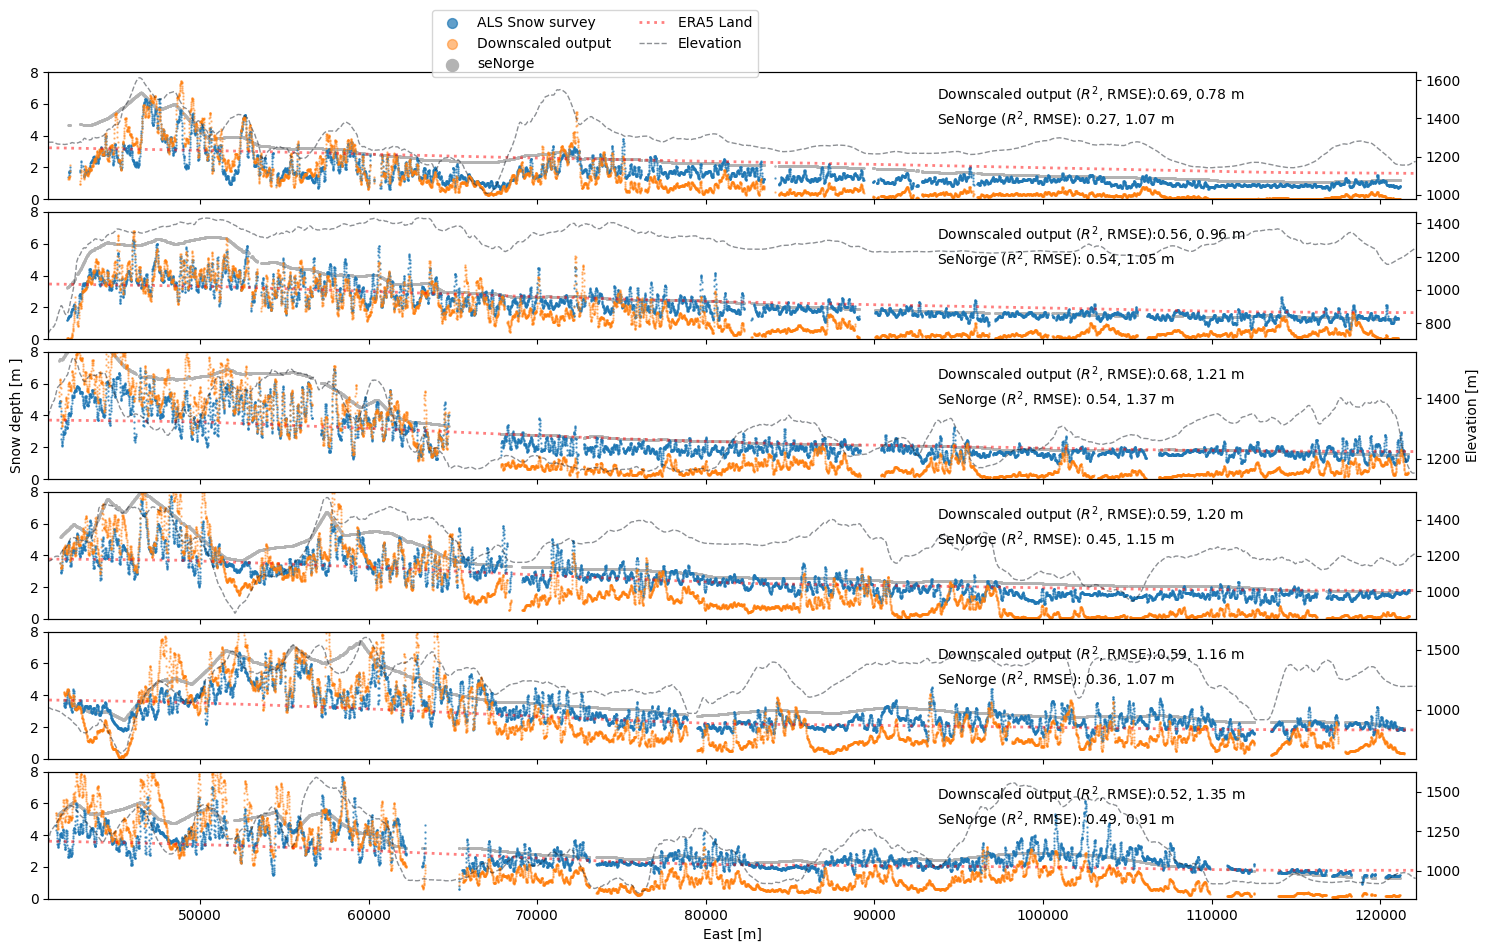

In [74]:
# OPEN SNOW DEPTH DATA from senorge
import xarray as xr
from xsnow.goplot import plot_metrics
from xsnow.goregression import quantile_mapping_xr, quantile_mapping_original_xr
import pickle

senorge = xr.open_dataset(r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\senorge\sd_2008.nc')
senorge_april = senorge.sel(time=slice('2008-04-01', '2008-04-30'),x=slice(41000, 130243), y=slice(6600000, 7200000))

test = case_6.timeseries.sel(time='2008-04-01').rename({'E':'x','N':'y'})

with open('adjust_factor_08_west.pkl', 'rb') as f:  # adjust_factor_08_test is from 
    adjust_factor = pickle.load(f )
    for als, factor in adjust_factor.items():
        #quantile_mapping_xr(test,factor['delta_lt1'],factor['delta_gt1'],dem=als, split=0,offset=0)
        quantile_mapping_original_xr(test,factor['delta_gt1'],factor['dem_q_gt1'],dem=als, split=0,offset=0)

# Usage
v1_list, v2_list, vh_list, vs_list,ve_list, x_list = extract_along_line(test.sd_predict_dtm1_.where(test.lake_mask == 0),
                                                               als_m.where(als_m > 0),
                                                               test.z,
                                                               senorge_april.snow_depth.mean(dim='time') / 100,
                                                               test.sde_era)

data_m,data_s = plot_scatter_snow_depth(v1_list, v2_list, vh_list, vs_list,ve_list,x_list,
                                        window_size_x=10,
                                        title='../results/snowdepth_senoreg_scatter_08_case6_10_corr.jpg')


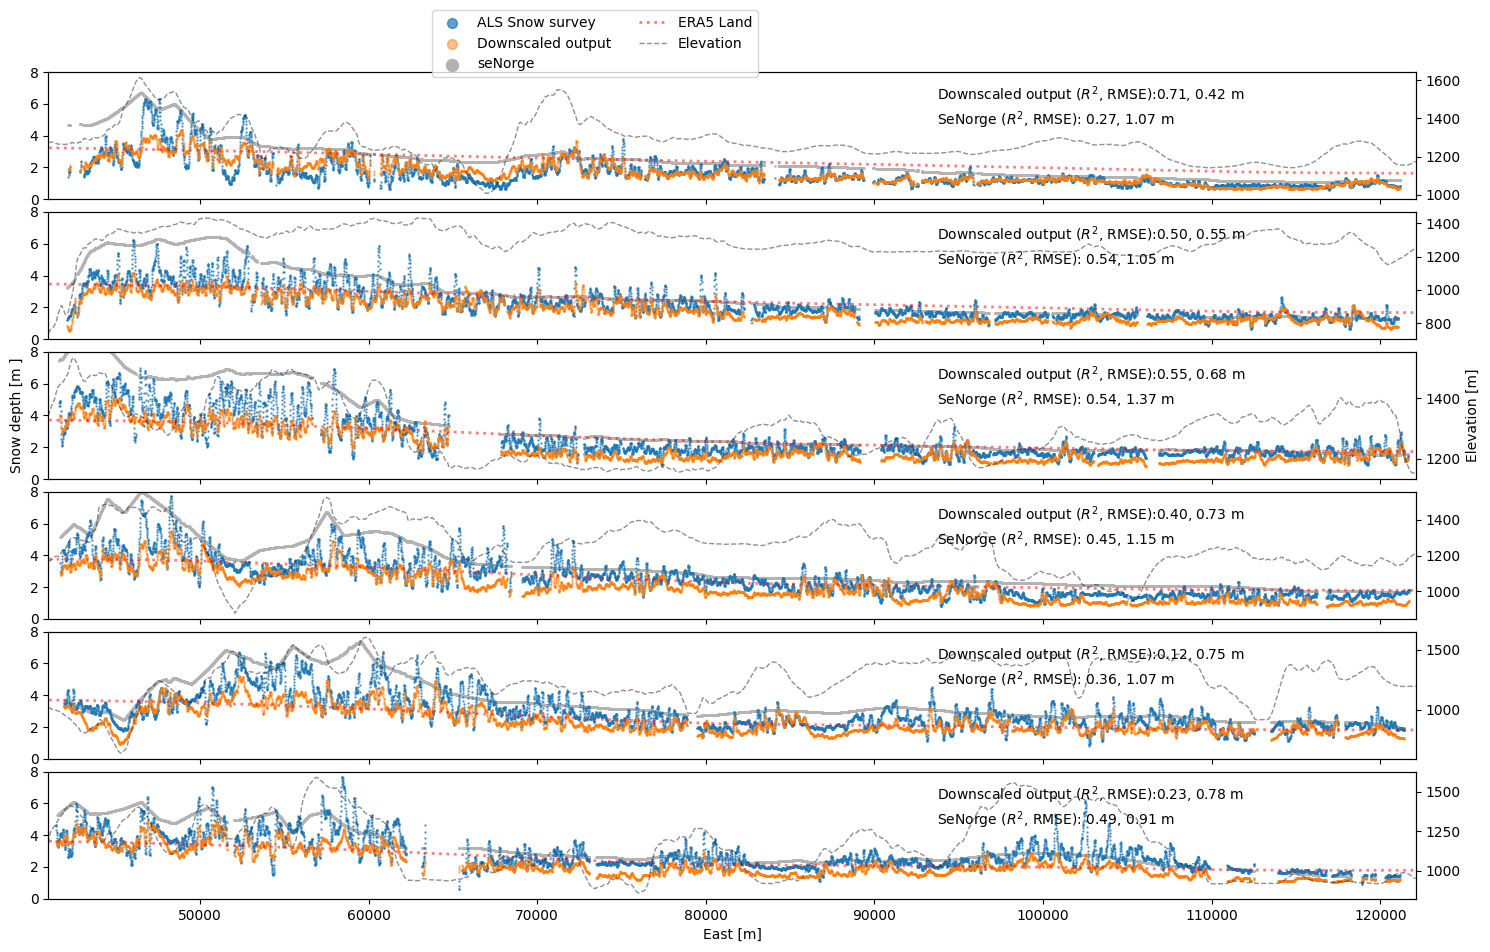

In [29]:
v1_list, v2_list, vh_list, vs_list,ve_list, x_list = extract_along_line(test.sd_predict_dtm1.where(test.lake_mask == 0) -1,
                                                               als_m.where(als_m > 0),
                                                               test.z,
                                                               senorge_april.snow_depth.mean(dim='time') / 100,
                                                               test.sde_era)

data_m,data_s = plot_scatter_snow_depth(v1_list, v2_list, vh_list, vs_list,ve_list,x_list,
                                        window_size_x=10,
                                        title='../results/snowdepth_senoreg_scatter_08_case6_10_original.jpg')

In [ ]:
import rioxarray
import rasterio
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, r2_score
import pickle
reload(xsnow.goregression)
from xsnow.goregression import quantile_mapping_original_xr, quantile_mapping_xr
import xarray as xr

# Senorge 08
senorge = xr.open_dataset(r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\senorge\sd_2008.nc')
senorge_april = senorge.sel(time=slice('2008-04-01', '2008-04-30'),x=slice(41000, 130243), y=slice(6600000, 7200000))

# ALS 08
dem_path = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\nve_08_merge_m.tif' # Path to the DEM TIFF file
als = rioxarray.open_rasterio(dem_path)
test = case_6.timeseries.sel(time='2008-04-01').rename({'E':'x','N':'y'})
test.rio.set_crs(als.rio.crs)
als = als.where(als != als.rio.nodata).squeeze()
als_m = als.rio.reproject_match(test)

# add correct value for test (xr.Dataset)
with open('adjust_factor_08_case6.pkl', 'rb') as f:
    adjust_factor = pickle.load(f)
    for als, factor in adjust_factor.items():
        #quantile_mapping_original_xr(test,factor['delta_gt1'],factor['dem_q_gt1'],dem=dem, split=0)
        quantile_mapping_xr(test,factor['delta_lt1'],factor['delta_gt1'],dem=als, split=0)

def plot_all_meso(test,dem_m,senorge_april,mask,
                  year='08_',case='_case7',
                  cols=['sd_predict_dtm1','sd_predict_dtm10','sd_predict_cop30','sd_predict_fab']):

    table_08 = []

    for dem in cols:
        v1_list, v2_list, vh_list, vs_list,ve_list,x_list = extract_along_line(test[dem].where(mask.rename({'E':'x','N':'y'}) == 0) -1,
                                                                       dem_m.where(dem_m > 0),
                                                                       test.z,
                                                                       senorge_april.snow_depth.mean(dim='time') / 100,
                                                                       test.sde_era)
        data_m,data_s = plot_scatter_snow_depth(v1_list, 
                                                v2_list, 
                                                vh_list, 
                                                vs_list,
                                                ve_list,
                                                x_list,
                                                window_size_x=10,
                                                title='snowdepth_senoreg_scatter_' + year + dem.split('_')[2] + case + '.jpg');
        
        table = pd.DataFrame(data_m, index=['r_2', 'ksd', 'spearman', 'rmse']).transpose().melt(var_name='metrics', value_name='value')
        table['dataset'] = dem.split('_')[2].upper()
        table_08.append(table)
    table_s = pd.DataFrame(data_s, index=['r_2', 'ksd', 'spearman', 'rmse']).transpose().melt(var_name='metrics', value_name='value')
    table_s['dataset'] = 'seNorge'
    table_08.append(table_s)
    
    return table_08

table_08 = plot_all_meso(test,
                         als_m, 
                         senorge_april, 
                         mask,
                         year='08_',
                         case='_case6_10_original');

In [ ]:
# ALS 09
dem_path = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\nve_09_merge_m.tif' # Path to the DEM TIFF file
als = rioxarray.open_rasterio(dem_path)
test_09 = case_6.timeseries.sel(time='2009-04-01').rename({'E':'x','N':'y'})
test_09.rio.set_crs(als.rio.crs)
als = als.where(als != als.rio.nodata).squeeze()
dem_sd_09 = als.rio.reproject_match(test_09)

# add correct value for test (xr.Dataset)
with open('adjust_factor_09_case6.pkl', 'rb') as f:
    adjust_factor = pickle.load(f)
    for als, factor in adjust_factor.items():
        #quantile_mapping_original_xr(test_09,factor['delta_gt1'],factor['dem_q_gt1'],dem=dem, split=0)
         quantile_mapping_xr(test_09,factor['delta_lt1'],factor['delta_gt1'],dem=als, split=0)
         
# Senorge 09
senorge_09 = xr.open_dataset(r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\senorge\sd_2009.nc')
senorge_april_09 = senorge_09.sel(time=slice('2009-04-01', '2009-04-30'),x=slice(41000, 130243), y=slice(6600000, 7200000))

table_09 = plot_all_meso(test_09,
                         dem_sd_09, 
                         senorge_april_09,
                         mask,
                         year='09_',
                         case='_case6_10_corr');

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_08 = pd.concat(table_08)
df_08['yaer'] = '2008'
df_09 = pd.concat(table_09)
df_09['yaer'] = '2009'
df_08.reset_index(drop=True, inplace=True)
df_09.reset_index(drop=True, inplace=True)

metric_name_mapping = {
    "r_2": "$R^2$",
    "spearman": "$\\rho$",
    "rmse": "RMSE [m]",
    "ksd": "KSD",
}

df_08['metrics'] = df_08['metrics'].map(metric_name_mapping)
df_09['metrics'] = df_09['metrics'].map(metric_name_mapping)

def plot_metrics_chart(df_08, label='2008', title='snowdepth_senoreg_scatter_08_case6_metrics.jpg'):
    # Define the desired order of the metrics
    desired_order = ["$R^2$", "$\\rho$", "RMSE [m]", "KSD"]
    #custom_palette = [sns.set_hls_values(color, l=0.3,s=0.7) for color in ["lime",'olive','crimson','royalblue','orange']]
    custom_palette = [#"#1f77b4", # Strong blue for R1
            "#ff7f0e", # Strong orange for A1
            "#e7ba52", # Lighter orange for A2
            "#2ca02c", # Strong green for B1
            "#17becf", # Lighter blue for B2
            "#b3b3b3"  # Muted grey for R2
            ]
    sns.set_theme(style="whitegrid")

    # Initialize the figure
    f, ax = plt.subplots()
    sns.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sns.stripplot(
        data=df_08, x="value", y="metrics", hue="dataset",
        dodge=True, alpha=.35, zorder=1, legend=False, palette=custom_palette,
        order=desired_order  # Specify the desired order here
    )

    # Show the conditional means, aligning each pointplot in the center of the strips
    sns.pointplot(
        data=df_08, x="value", y="metrics", hue="dataset",
        dodge=.8 - .8 / 3, palette=custom_palette, errorbar=None,
        markers="d", linestyles="none",
        order=desired_order  # Specify the desired order here
    )

    ax.set(xlim=(0, 1.15))
    # Remove the dataset title from the legend
    legend = ax.get_legend()
    legend.set_title('')

    # Improve the legend
    sns.move_legend(
        ax, loc="lower right", ncol=2, frameon=False, columnspacing=1, handletextpad=0,
    )
    # Remove y-axis and x-axis labels
    ax.set_ylabel('')
    ax.set_xlabel(label)
    plt.tight_layout()  # Add this line to make the plot tight

    plt.savefig(title,dpi=600)
    plt.show()

plot_metrics_chart(df_08,label='2008',title='2008_metrics_case6_10_corr.jpg')
plot_metrics_chart(df_09,label='2009',title='2009_metrics_case6_10_corr.jpg')

# Assuming you have two DataFrames: df_08 and df_09
combined_df = pd.concat([df_08, df_09])
# If you want to reset the index of the combined DataFrame
combined_df = combined_df.reset_index(drop=True)

# 
plot_metrics_chart(combined_df,label='Values',title='2008_2009_metrics_case6_10_corr.jpg')

#### 3.2 plot snow depth map vs Senorge data

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as mcm
import datashader.transfer_functions as tf
from matplotlib.colors import Normalize
from xrspatial import hillshade
import colorcet as cc

def comparison(comparison_08,senorge_april,dem='sd_predict_dtm1_',title="snowdepth_senoreg_map.jpg",cmap='Spectral',alpha=150,vmax=5):

    fig = plt.figure(figsize=(13, 8))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05])

    # Basemap using Datashader and embed it in one of the subplots
    terrain = comparison_08.z
    illuminated = hillshade(terrain)

    img = tf.stack(
        tf.shade(terrain, cmap=["black", "white"], how="linear"),
        tf.shade(illuminated,  cmap=["black", "white"], how="linear", alpha=100)
    )

    # Set the extent based on your data if needed
    extent = [comparison_08.x.min(), comparison_08.x.max(), comparison_08.y.min(), comparison_08.y.max()]

    # Hide all titles and display the combined basemap
    for i in range(2):
        for j in range(2):
            ax = plt.subplot(gs[i, j])
            ax.set_title('')
            ax.imshow(img.to_pil(), extent=extent)
            ax.label_outer()
            
    if 'lake_mask' in comparison_08:
        mask = comparison_08['lake_mask']
    else:
        mask = comparison_08[dem].where(comparison_08[dem] > 0)

    # (0,0) reference ERA5 in 9 KM resolution
    p_00 = tf.shade(comparison_08.sde_era, cmap=mcm.get_cmap(cmap), how="linear", alpha=alpha, span=[0, vmax])
    ax = plt.subplot(gs[0, 0])
    ax.imshow(p_00.to_pil(), extent=extent)

    # (0,1) original
    p_01 = tf.shade(comparison_08[dem].where(mask==0), cmap=mcm.get_cmap(cmap), how="linear", alpha=alpha, span=[0, vmax])
    ax = plt.subplot(gs[0, 1])
    ax.imshow(p_01.to_pil(), extent=extent)

    # (1,0) plot senorge
    p_10 = tf.shade(senorge_april.snow_depth.mean(dim='time') / 100, cmap=mcm.get_cmap(cmap), how="linear", alpha=alpha, span=[0, vmax])
    ax = plt.subplot(gs[1, 0])
    ax.imshow(p_10.to_pil(), extent=extent)

    # (1,1) Coarsen xarray.Dataset into 1 km resolution
    p_11 = tf.shade(comparison_08[dem].where(mask==0).coarsen(x=100, y=100, boundary='pad').mean(), cmap=mcm.get_cmap(cmap), how="linear", alpha=alpha, span=[0, 5])
    ax = plt.subplot(gs[1, 1])
    ax.imshow(p_11.to_pil(), extent=extent)

    # Create a colorbar
    norm = Normalize(vmin=0, vmax=vmax)  # Adjust the vmin and vmax as needed
    scalar_map = plt.cm.ScalarMappable(cmap=mcm.get_cmap(cmap), norm=norm)
    scalar_map.set_array([])  # Provide an empty array
    cax = plt.subplot(gs[:, 2])
    cbar = plt.colorbar(scalar_map, cax=cax, orientation='vertical',shrink=0.5)
    cbar.set_label('Snow depth [m]', fontsize=16)  # Customize the label as needed
    cbar.ax.set_aspect(5.7)  # Adjust the aspect ratio to control the length

    cbar.ax.tick_params(labelsize=14)  # Set label size

    
    plt.tight_layout()
    plt.savefig(title, dpi=600)
    plt.show()

# OPEN SNOW DEPTH DATA from senorge
import xarray as xr
senorge_08 = xr.open_dataset(r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\senorge\sd_2008.nc')

# 08 choose the dataset
comparison(case_6.timeseries.sel(time='2008-04-01').rename({'E':'x','N':'y'}), 
           senorge_08.sel(time=slice('2008-04-01', '2008-04-30'),x=slice(41000, 125000), y=slice(6650000,6700092)),
           dem='sd_predict_dtm1_',
           title="snowdepth_senoreg_map_08_case6_corr.jpg",
           cmap='Spectral',#'RdYlBu',
           alpha=180)

# 09
#senorge_09 = xr.open_dataset(r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\senorge\sd_2009.nc')
#comparison(case_60.timeseries.sel(time='2009-04-01').rename({'E':'x','N':'y'}), 
#           senorge_09.sel(time=slice('2009-04-01', '2009-04-30'),x=slice(41000, 125000), y=slice(6650000,6700092)),
#           dem='sd_predict_dtm1_',title="snowdepth_senoreg_map_09_case6_corr.jpg",
#           cmap='Spectral')


#### 3.3 Model prediction visual inspection by Sentinel

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as mcm
import datashader.transfer_functions as tf
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from xrspatial import hillshade
from matplotlib.ticker import MaxNLocator 
import numpy as np

def comparison_edge(comparison_08,senorge_april=None,cmap='Spectral',dem='sd_predict_dtm1_',offset=0,title="snowdepth_senoreg_map.jpg"):

    fig,ax = plt.subplots(figsize=(12, 8))
    
    # Basemap using Datashader and embed it in one of the subplots
    terrain = comparison_08.z
    illuminated = hillshade(terrain)

    # Set the extent based on your data if needed
    extent = [comparison_08.x.min(), comparison_08.x.max(), comparison_08.y.min(), comparison_08.y.max()]

    img = tf.stack(
        tf.shade(terrain, cmap=["black", "white"], how="linear"),
        tf.shade(illuminated, cmap=["black", "white"], how="linear", alpha=150)
    )
    
    ax.imshow(img.to_pil(), extent=extent)
    
    # Hide all titles and display the combined basemap
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.xaxis.labelpad = 30

    # Original shade image
    #p_01 = tf.shade(comparison_08[dem], cmap=mcm.get_cmap(cmap), how="linear", alpha=150, span=[0, 2])

    # Create a custom colormap by modifying the original colormap
    custom_cmap = mcm.get_cmap(cmap, 256)
    custom_cmap_colors = custom_cmap(np.linspace(0, 1, 256))
    custom_cmap_colors[:int(0.055 * 256)] = [1, 1, 1, 1]  # Set values below 0.1 to white
    custom_cmap = ListedColormap(custom_cmap_colors)

    # Apply the custom colormap to the image
    p_01 = tf.shade(comparison_08[dem].where(comparison_08.lake_mask ==0) - offset, cmap=custom_cmap, how="linear", alpha=150, span=[0, 2])

    ax.imshow(p_01.to_pil(), extent=extent)

    # Create a colorbar using ScalarMappable
    norm = Normalize(vmin=0, vmax=2)
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])

    # Customize the colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5) 

    # Customize colorbar ticks and label size
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
    cbar.ax.tick_params(labelsize=14) 
    cbar.set_label('Snow depth [m]', fontsize=16)  

    plt.tight_layout()
    plt.savefig(title, dpi=600)
    plt.show()

comparison_edge(
    case_6.timeseries.sel(time='2020-06-01', N=slice(6649500, 6670000), E=slice(98961, 123200)).rename({'E': 'x', 'N': 'y'}),
    cmap='Spectral', dem='sd_predict_dtm1', title="m_snowdepth_senoreg_map_2020_case_6_original.jpg",offset=0.8)

#### 3.4 Micro scale

In [ ]:
import rioxarray
import rasterio
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, r2_score
from xsnow.misc import evaluate_difference
from xsnow.goplot import RMSE,plot_over_dem
#x is between 54000 to 60000
import datashader.transfer_functions as tf
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from xrspatial import hillshade
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_dem_plot_difference(dem_m,
                             model,
                             model_z,
                             xlim=(54000,56000),ylim=(6663946,6664442),
                             title='snowdepth_senoreg_profile.jpg'):
    
    color = ["#1f77b4", # Strong blue for R1
                "#ff7f0e", # Strong orange for A1
                "#e7ba52", # Lighter orange for A2
                "#2ca02c", # Strong green for B1
                "#17becf", # Lighter blue for B2
                "#b3b3b3"  # Muted grey for R2
                ]
    
    # (1) generate difference
    difference = model - dem_m

    # (2) Define your hard threshold and Z-score threshold and mask out
    hard_threshold = 20
    z_score_threshold = 3  # Adjust the Z-score threshold as needed
    hard_outliers = difference > hard_threshold
    da = difference.where(~hard_outliers)
    # Calculate the Z-scores for each data point
    z_scores = (da - da.mean()) / da.std()
    z_score_outliers = np.abs(z_scores) > z_score_threshold
    # Mask out the outliers
    combined_outliers = hard_outliers | z_score_outliers
    difference_map = difference.where(~combined_outliers)
    difference_map = difference_map.sel(x=slice(xlim[0],xlim[1]),y=slice(ylim[0],ylim[1]))
    
    # (3) Aggregate the difference map to x axis
    squeeze_N = difference_map.mean(dim='y')

    # (4) Draw profile
    n_profile=(ylim[0]+ylim[1])/2

    # A. Plot map of ALS
    fig, ax = plt.subplots(4,1,figsize=(14, 9),sharex=True,sharey=False,gridspec_kw={'height_ratios': [1, 1, 2, 2]})

    plot0 = dem_m.plot(ax=ax[1],cmap='Spectral', vmin=0, vmax=8,add_colorbar=False)
    ax[1].set_xlim(xlim[0],xlim[1])
    ax[1].set_ylim(ylim[0],ylim[1])

    # B. Plot map of model
    plot1 =model.plot(ax=ax[2],cmap='Spectral', vmin=0, vmax=8,add_colorbar=False)
    ax[2].set_ylim(ylim[0]-(ylim[1]-ylim[0]),ylim[1])

    # Create external color bars
    fig.subplots_adjust(right=1.00)
    cax0 = fig.add_axes([1, 0.45, 0.015, 0.28])  # Adjust these values as needed
    cax2 = fig.add_axes([1, 0.17, 0.015, 0.15])  # Adjust these values as needed
    cax0.set_label('Snow depth [m]')
    cax0.set_label('Difference [m]')

    # Create the shared color bar
    plt.colorbar(plot1, cax=cax0)
    
    # C. plot map of difference

    # Basemap using Datashader and embed it in one of the subplots
    # Set the extent based on your data if needed
    extent = [xlim[0], xlim[1], ylim[0]-(ylim[1]-ylim[0]),ylim[1]]
    z = model_z.sel(x=slice(xlim[0],xlim[1]),y=slice(ylim[0]-(ylim[1]-ylim[0]),ylim[1]))
    illuminated = hillshade(z)
    img = tf.stack(
        tf.shade(z, cmap=["black", "white"], how="linear"),
        tf.shade(illuminated, cmap=["black", "white"], how="linear", alpha=100)
    )
    ax[3].imshow(img.to_pil(), extent=extent, aspect='auto')
    
    # Plotting for ax[3] with its own color bar
    plot2 = difference_map.plot(ax=ax[3], cmap='coolwarm', vmin=-4, vmax=4,add_colorbar=False)
    ax[3].set_ylim(ylim[0]-(ylim[1]-ylim[0]),ylim[1])
    ax[3].set_xlim(xlim[0],xlim[1])
    ax[3].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

    plt.colorbar(plot2, cax=cax2)

    # statistics
    rmse_map = RMSE(difference_map)
    mean_map = np.nanmean(difference_map)
    print('rmse of map', rmse_map)
    
    # D. Profile plot

    # Plot variable on primary y-axis
    model.sel(y=n_profile, method='nearest').plot(ax=ax[0], color=color[1], label='Downscaled output')
    dem_m.sel(y=n_profile, method='nearest').plot(ax=ax[0], color=color[0], label='ALS snow survey')
    
    # Plot difference on secondary y-axis
    ax2 = ax[0].twinx()
    
    # Plot elevation on secondary y-axis
    z.sel(y=n_profile, method='nearest').plot(ax=ax2, color='#1c222b', label='Elevation', linestyle='--',alpha=0.5)

    # plot snow depth difference of transect on secondary y-axis
    #difference_map.sel(y=n_profile, method='nearest').plot(ax=ax2,color='green', label='profile')
    ax2.set_title('')
    ax2.set_xlabel('')
    ax[0].set_ylim((0,10))
    ax[0].set_xlim(xlim[0],xlim[1])
    ax[0].grid(False)
    ax2.grid(False)
    ax2.set_ylabel('Elevation [m]')
    ax[1].axhline(y=n_profile, color='white', linestyle='-', linewidth=1)
    ax[2].axhline(y=n_profile, color='white', linestyle='-', linewidth=1)
    ax[1].set_title('')
    ax[2].set_title('')
    ax[3].set_title('')
    ax[0].set_title('')
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')
    ax[3].set_xlabel('E')
    ax[1].set_ylabel('N')
    ax[2].set_ylabel('N')
    ax[3].set_ylabel('N')
    ax[3].text(0.85, 0.72, f'RMSE:{rmse_map:.2f} m', transform=ax[3].transAxes, ha='left', va='top')
    ax[3].text(0.85, 0.64, f'Mean:{mean_map:.2f} m', transform=ax[3].transAxes, ha='left', va='top')
    ax[0].set_ylabel('Snow depth [m]')
    #ax[0].tick_params(axis='x', which='both', bottom=False, top=True, labeltop=False)

    # Combine legends for both y-axes
    lines1, labels1 = ax[0].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax[0].legend(lines1 + lines2, labels1 + labels2, loc = 'upper left',framealpha=0.4)

    # statistics
    correlation, ksd, r2, _ = evaluate_difference(model.sel(y=n_profile, method='nearest'), dem_m.sel(y=n_profile, method='nearest'))
    # aggregated 
    rmse = mean_squared_error(squeeze_N.dropna(dim='x'), np.zeros_like(squeeze_N.dropna(dim='x')),squared=False)
    nmad = xdem.spatialstats.nmad(squeeze_N)
    
    print(f"rmse of profile: {_:.2f}")
    
    text_str = f"ρ: {correlation:.2f}\n$R^2$: {r2:.2f}\nRMSE: {_:.2f} m\nKSD: {ksd:.2f}"
    ax[0].text(0.85, 0.92, text_str, transform=ax[0].transAxes, ha='left', va='top')

    print(f"Spearman's Correlation: {correlation:.2f}")
    print(f"R-squared: {r2:.2f}")
    print(f"RMSE: {rmse:.2f}")
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.1) # Adjust this value as needed
    plt.savefig('a_'+title, dpi=600, bbox_inches='tight')
    return difference_map


In [ ]:
import numpy as np
from xsnow.goregression import quantile_mapping_xr
import xdem 

als_path = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\nve_08_merge_m.tif' # Path to the DEM TIFF file
als = rioxarray.open_rasterio(als_path)
test = case_6.timeseries.sel(time='2008-04-01').rename({'E':'x','N':'y'})
test.rio.set_crs(als.rio.crs)
als = als.where(als != als.rio.nodata).squeeze()
als_m = als.rio.reproject_match(test)

# add correct value for test (xr.Dataset)
with open('adjust_factor_08_case6.pkl', 'rb') as f:
    adjust_factor = pickle.load(f)
    for als, factor in adjust_factor.items():
        #quantile_mapping_original_xr(test,factor['delta_gt1'],factor['dem_q_gt1'],dem=dem, split=0)
        quantile_mapping_xr(test,factor['delta_lt1'],factor['delta_gt1'],dem=als, split=0)

load_dem_plot_difference(als_m,test.sd_predict_dtm1_,test.z,xlim=(54000,61000),ylim=(6694752,6695306),title='snowdepth_profile_08_case6_corr.jpg');
load_dem_plot_difference(als_m,test.sd_predict_dtm1 -1,test.z,xlim=(54000,61000),ylim=(6694752,6695306),title='snowdepth_profile_08_case6_original.jpg');#


In [ ]:
load_dem_plot_difference(als_m,test.sd_predict_dtm1 -1,test.z,xlim=(54000,61000),ylim=(6694752,6695306),title='snowdepth_profile_08_case6_original.jpg');#


In [ ]:
import pickle
from xsnow.goregression import quantile_mapping_xr 
als_path = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\nve_09_merge_m.tif' # Path to the DEM TIFF file
als = rioxarray.open_rasterio(als_path)
test = case_6.timeseries.sel(time='2009-04-01').rename({'E':'x','N':'y'})
test.rio.set_crs(als.rio.crs)
als = als.where(als != als.rio.nodata).squeeze()
als_m = als.rio.reproject_match(test)
import xdem

test = case_6.timeseries.sel(time='2009-04-01').rename({'E':'x','N':'y'})
with open('adjust_factor_09_case6.pkl', 'rb') as f:
    adjust_factor = pickle.load(f)
    for dem, factor in adjust_factor.items():
        #quantile_mapping_original_xr(test,factor['delta_gt1'],factor['dem_q_gt1'],dem=dem, split=0)
        quantile_mapping_xr(test,factor['delta_lt1'],factor['delta_gt1'],dem=dem, split=0)#

load_dem_plot_difference(als_m,test.sd_predict_dtm1_,test.z,xlim=(54000,61000),ylim=(6694752,6695306),title='snowdepth_profile_09_case6_corr.jpg');
load_dem_plot_difference(als_m,test.sd_predict_dtm1 -1,test.z,xlim=(54000,61000),ylim=(6694752,6695306),title='snowdepth_profile_09_case6_original.jpg');

##### 3.4.1 There are snow pacthes in DTM1, validated by ALS bare ground data.

In [ ]:
dtm_path = r'\\hypatia.uio.no\lh-mn-geofag-felles\projects\snowdepth\zhihaol\data\Snow_depth_on_Hardangervidda_2008-2009\Snow_depth_on_Hardangervidda_2008-2009\FlightLine_2_DTM_200809.tif' # Path to the DEM TIFF file
dtm = rioxarray.open_rasterio(dtm_path)

In [ ]:
from rasterio.enums import Resampling
from xsnow.goplot import normal_statistics
from noisyopt import minimizeCompass

# read
dtm_ = dtm.rio.reproject_match(test).where(dtm_ >0)

def get_dh_by_shift_px_xr(test,dtm_,shift_m,return_dh=False):
    # shift
    dtm_shift = dtm_.assign_coords({"x": (dtm_.x + shift_m[0]),'y': (dtm_.y + shift_m[1])})
    # difference
    difference_map = dtm_shift.rio.reproject_match(test, resampling = Resampling.bilinear) - test.z
    # loss
    res = {}
    res['mean'],res['median'],res['std'],res['rmse'],res['num'],res['nmad'] = normal_statistics(difference_map , perc_t = 100, std_t = None)
    if return_dh:
        return difference_map

    return res['nmad']


#func_x = lambda x: get_dh_by_shift_px_xr(test,dtm_,x)
#res = minimizeCompass(func_x, x0=(0,0), deltainit=5,deltatol=0.006,feps=0.0002,bounds=([-10,10],[-10,10]),disp=True,errorcontrol=False)
    

In [ ]:
difference_map = get_dh_by_shift_px_xr(test,dtm_,(-2.8125,  3.125),return_dh=True)


In [ ]:
# plot

xlim=(54000,61000)
ylim=(6694752,6695306)
fig, ax = plt.subplots(1,1,figsize=(16, 2),dpi=600)
difference_map.sel(x=slice(xlim[0],xlim[1]),y=slice(ylim[0],ylim[1])).plot(cmap='coolwarm_r', vmin=-4, vmax=4,ax=ax)

#### 3.5 Time series


In [ ]:
import pandas as pd

case_m = Snow_Distributor(new_df,
                          era,
                          features=['E','N','h_te_best_fit','slope', 'aspect', 
                                  'planc','profc','tpi','tpi_9','tpi_27',
                                  'curvature','sde_era','wf_positive', 
                                  'wf_negative','month'],
                          regressor_list = ['sd_dtm1_abserror_250_10_qc_nve_geosegment_abs.json',
                                             'sd_dtm10_abserror_250_10_qc_nve_geosegment_abs.json',
                                             'sd_cop30_abserror_250_10_qc_nve_geosegment_abs.json',
                                             'sd_fab_abserror_250_10_qc_nve_geosegment_abs.json'],
                          crop=[6649500, 6670000, 98961, 123200])

case_m.product_time_series(start_date = pd.to_datetime('20150101'), correction='qm',regression='MAD');
case_m.timeseries = case_m.mask_out_lake()

In [ ]:
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
import datashader.transfer_functions as tf
import matplotlib.cm as cm
import holoviews as hv, datashader as ds, geoviews as gv, geoviews.tile_sources as gvts
import imageio
from matplotlib.colors import ListedColormap

def plot_snow_depth_gif_3d(ds_timeseries,variable = 'sd_predict_dtm1_',cmap=cm.get_cmap('Spectral'),offset=0):

        # Assuming you have an xarray Dataset named 'ds' with dimensions 'N', 'E', and 'time'

        # Create an empty list to store the images
        images = []

        terrain = ds_timeseries.z
        illuminated = hillshade(terrain)

        # Create a custom colormap by modifying the original colormap
        custom_cmap = cmap
        #custom_cmap = mcm.get_cmap(cmap, 256)
        #custom_cmap_colors = custom_cmap(np.linspace(0, 1, 256))
        #custom_cmap_colors[:int(0.055 * 256)] = [1, 1, 1, 1]  # Set values below 0.1 to white
        #custom_cmap = ListedColormap(custom_cmap_colors)

        # Iterate over the time dimension
        for t in ds_timeseries.time:
            # Extract the data for the specific time slice
            data_slice = ds_timeseries[variable].sel(time=t) - offset
  
            # Create a map plot

            # Plot the terrain, illuminated layer, and snow depth using stack
            img = tf.stack(
                shade(terrain, cmap=["black", "white"], how="linear"),
                shade(illuminated, cmap=["black", "white"], how="linear", alpha=150),
                shade(data_slice, cmap=custom_cmap, how="linear", alpha=180, span=[0, 2])
            )

            # Format the time for the plot title
            t_formatted = t.dt.strftime('%Y-%m').item()

            # Save the figure as an image
            filename = f"{t_formatted}.jpg"
   
            ds.utils.export_image(img, t_formatted, background='white', export_path='.')

            # Append the image to the list
            images.append(imageio.imread(filename))

        # Save the list of images as a GIF
        imageio.mimsave('animation_3d_.gif', images, duration=0.8)

def plot_snow_depth_gif_chart(ds_timeseries, variable='sde_predict_dtm1',offset=0):
        # Create an empty list to store the images
        images = []


        # Plot scatter for each time snapshot
        for t in ds_timeseries.time:
            # Plot chart for mean value
            fig, ax = plt.subplots(figsize=(10, 3))

            mean_series = ds_timeseries[variable].mean(dim=['N', 'E']) - offset
            mean_series.plot(x='time', ax=ax)
            ax.set_ylabel('Mean Snow depth (m)')

            plt.scatter(t, mean_series.sel(time=t), c='red', marker='o')

            # Format the time for the plot title
            t_formatted = t.dt.strftime('%Y-%m').item()
            ax.set_title(f'Monthly Snow Depth - {t_formatted}',fontsize=20)

            # Save the figure as an image
            filename = f"{t_formatted}.jpg"
            plt.savefig(filename, dpi=100)
            plt.close(fig)

            # Append the image to the list
            images.append(imageio.imread(filename))

        # Save the list of images as a GIF
        imageio.mimsave('animation_chart.gif', images, duration=0.8)


In [ ]:
plot_snow_depth_gif_3d(case_m.timeseries.sel(N=slice(6649500, 6670000), E=slice(98961, 123200)),variable = 'sd_predict_dtm1',offset=1)

In [ ]:
plot_snow_depth_gif_chart(case_m.timeseries.sel(N=slice(6657480, 6657520), E=slice(105000, 105040)),variable='sd_predict_dtm1',offset=0)

#### 3.6 Weather station data

In [ ]:
# read frost data

from xsnow.read_frost import find_station,read_frost_loop

station_list = find_station(country=None,polygon=None,sources='SN46510,SN33990,SN33950,SN33890,SN31680,SN29400,SN31660')
station_list[station_list['id'] == 'SN33950'][['E', 'N']]
station_list

In [ ]:
station_measurements = read_frost_loop(sources=['SN33950','SN29400','SN31660'], #'SN33990','SN46510','SN33890'
                          elements=['mean(surface_snow_thickness P1M)','max(surface_snow_thickness P1M)','min(surface_snow_thickness P1M)'],
                          referencetime='2008-01-01/2022-12-01')

#station_d_snow = read_frost_loop(sources=['SN46510','SN33990','SN33950','SN33890'],
#                          elements=['max(surface_snow_thickness P1M)'],
#                          referencetime='2015-01-01/2022-12-01')

In [ ]:
import matplotlib.pyplot as plt
from importlib import reload
import xsnow.misc
reload(xsnow.misc)
from xsnow.misc import temporal_statistic

def compare_with_station(station_m_snow,
                         station_list,
                         case,
                         station='SN33950',
                         nn=None,
                         ee=None,
                         name=None,
                         offset=0,
                         dem='sd_predict_dtm1_',
                         ax=None):

    if ax is None:
        fig,ax = plt.subplots(1,2,figsize=(16,3), gridspec_kw={'width_ratios': [4,1]},dpi=600)

    s_mean = station_m_snow[station_m_snow['elementId']=='mean(surface_snow_thickness P1M)']['value'] /100
    s_min = station_m_snow[station_m_snow['elementId']=='max(surface_snow_thickness P1M)']['value'] /100
    s_max= station_m_snow[station_m_snow['elementId']=='min(surface_snow_thickness P1M)']['value'] /100

    # plot station
    s_mean.plot(ax=ax[0],label='Weather station')
    ax[0].fill_between(s_mean.index, s_min, s_max, color='blue', alpha=0.15)

    # plot model
    if nn is None:
        nn = station_list[station_list['id'] == station]['N'].values[0]
    
    if ee is None:
        ee = station_list[station_list['id'] == station]['E'].values[0]
    
    # sd_predict_dtm1 or sd_predict_dtm1_                    
    model_sd = case.timeseries.sel(N=slice(nn-10,nn+10),E=slice(ee-10,ee+10)).mean(dim=['N','E'])
    
    # adjust offset and clip negative prediction.
    model_sd[dem] = (model_sd[dem]- offset).clip(min=0)
    model_sd[dem].plot(ax=ax[0],label='Downscaled output (10 m)',alpha=0.8)
    model_sd.sde_era.plot(ax=ax[0],label='ERA5 Land',color='red',alpha=0.5,linestyle='--')
    
    if f'{dem}_25' in model_sd:
        model_sd[f'{dem}_25'] = (model_sd[f'{dem}_25']- offset).clip(min=0)
        model_sd[f'{dem}_75'] = (model_sd[f'{dem}_75']- offset).clip(min=0)
        ax[0].fill_between(model_sd[dem].time, model_sd[f'{dem}_25'], model_sd[f'{dem}_75'], color='yellow', alpha=0.25)

    # plot the map
    sd_to_plot = case.timeseries[dem].mean(dim=['time']) - offset
    map_label = "Average snow depth [m]"
    if f'{dem}_25' in model_sd:
            sd_to_plot = (case.timeseries[f'{dem}_75'] - case.timeseries[f'{dem}_25']).mean(dim=['time'])
            map_label = 'Snow depth IQR [m]'
    sd_to_plot.sel(N=slice(nn-250,nn+250),E=slice(ee-250,ee+250)).plot(ax=ax[1],cmap='Spectral', vmin=0, vmax=model_sd.sde_era.max(), cbar_kwargs={"label": map_label})
    ax[1].scatter(ee, nn, color='black', marker='o',facecolors='none')
    ax[1].annotate(name, (ee, nn), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Add RMSE and R-squared values to the plot
    dict_output = temporal_statistic(model_sd[dem].values.flatten(), s_mean.values,model_sd.time.values,s_mean.index.values)
    text_str = f"RMSE: {dict_output['rmse']:.2f} m\n$R^2$: {dict_output['r2']:.2f}\nρ: {dict_output['spearman_r']:.2f}\n$KSD$: {dict_output['ks']:.2f}"

    formatted_output = {key: f'{value:.3f}' for key, value in dict_output.items() if key in ['N','rmse','r2','spearman_r','ks']}
    print(f'Output:\n{formatted_output}')
    
    # Era5 land metrics
    dict_era5 = temporal_statistic(model_sd.sde_era.values.flatten(), s_mean.values,model_sd.time.values,s_mean.index.values)
    formatted_output_era = {key: f'{value:.3f}' for key, value in dict_era5.items() if key in ['N','rmse','r2','spearman_r','ks']}
    print(f'ERA5 land:\n{formatted_output_era}')
    
    ax[0].text(0.85, 0.95, text_str, transform=ax[0].transAxes, ha='left', va='top')
    ax[0].set_ylabel('Snow depth [m]')
    ax[0].set_xlabel('')
    ax[0].tick_params(axis='x', which='minor', bottom=False)
    

    ax[0].legend()
    #ax[0].set_title(name)

    return dict_output, ax


In [ ]:
import pandas as pd

# Assuming you have a DataFrame called station_list
stations = pd.DataFrame({
    'id': ['SN31660', 'SN31661', 'SN31662'],
    'N': [station_list[station_list['id'] == 'SN29400']['N'].values[0], 
          station_list[station_list['id'] == 'SN31660']['N'].values[0],
          station_list[station_list['id'] == 'SN33950']['N'].values[0]],
    'E': [station_list[station_list['id'] == 'SN29400']['E'].values[0], 
          station_list[station_list['id'] == 'SN31660']['E'].values[0],
          station_list[station_list['id'] == 'SN33950']['E'].values[0]],
})

# Define the buffer size
buffer_size = 250

# Create a list to store subsets for each station
subsets = []

# Iterate through each station
for station_id, station_data in stations.iterrows():
    # Get the station's N and E coordinates
    station_n = station_data['N']
    station_e = station_data['E']
    
    # Create a subset by filtering based on coordinates
    subset = new_df[
        (new_df['N'] >= station_n - buffer_size) &
        (new_df['N'] <= station_n + buffer_size) &
        (new_df['E'] >= station_e - buffer_size) &
        (new_df['E'] <= station_e + buffer_size)
    ].copy()  # Add .copy() to create an independent copy
    
    # Append the subset to the list
    subsets.append(subset)

# Concatenate the subsets into a single DataFrame
df_station = pd.concat(subsets)

In [ ]:
from importlib import reload
import xsnow.goregression
import xsnow.read_frost
reload(xsnow.goregression)
reload(xsnow.read_frost)
from xsnow.goregression import Snow_Distributor
import pandas as pd

case_station_6 = Snow_Distributor(df_station,era,
                                features=['E', 'N','h_te_best_fit','slope', 'aspect', 
                                'planc','profc','tpi','tpi_9','tpi_27',
                                'curvature','sde_era','wf_positive', 
                                'wf_negative','month'])

case_station_6.regressor_list = ['sd_dtm10_abserror_250_10_qc_nve_geosegment_square.json',
                                'sd_dtm1_abserror_250_10_qc_nve_geosegment_square.json',
                                'sd_cop30_abserror_250_10_qc_nve_geosegment_square.json',
                                'sd_fab_abserror_250_10_qc_nve_geosegment_square.json']

# generate time series
case_station_6.product_time_series(correction='qm',regression='other')
case_station_6.timeseries = case_station_6.mask_out_lake(is_plot=False)

In [ ]:
from importlib import reload
import xsnow.goregression
import xsnow.read_frost
reload(xsnow.goregression)
reload(xsnow.read_frost)
from xsnow.goregression import Snow_Distributor
import pandas as pd

case_station_5 = Snow_Distributor(df_station,era,
                                features=['E', 'N','h_te_best_fit','slope', 'aspect', 
                                'planc','profc','tpi','tpi_9','tpi_27',
                                'curvature','sde_era','wf_positive', 
                                'wf_negative','month'])

case_station_5.regressor_list = ['sd_dtm10_abserror_250_10_qc_nve_quantile_3.json',
                                'sd_dtm1_abserror_250_10_qc_nve_quantile_3.json',
                                'sd_cop30_abserror_250_10_qc_nve_quantile_3.json',
                                'sd_fab_abserror_250_10_qc_nve_quantile_3.json']

# generate time series
case_station_5.product_time_series(correction='qm',regression='quantile_regression')
case_station_5.timeseries = case_station_5.mask_out_lake(is_plot=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

def plot_station_timeseries(case_s,station_list,dem='sd_predict_dtm1_',offset=0,title='case.jpg'):

    fig, ax = plt.subplots(3, 2, figsize=(16, 11), gridspec_kw={'width_ratios': [4, 1]}, dpi=600, sharex=False)
    
    # Disable sharing of x-axis for the subplots in the second column
    for i in range(3):
        ax[i, 0].sharex(ax[0, 0])

    metrics_a, ax_a = compare_with_station(station_measurements[station_measurements['station_id'] == 'SN29400'],
                        station_list,
                        case_s,
                        station='SN29400',
                        name='Sandhaug',
                        nn=station_list[station_list['id'] == 'SN29400']['N'].values[0],
                        ee=station_list[station_list['id'] == 'SN29400']['E'].values[0],
                        dem=dem,
                        offset=offset,
                        ax=(ax[0,0],ax[0,1]))

    metrics_b, ax_b = compare_with_station(station_measurements[station_measurements['station_id'] == 'SN31660'],
                        station_list,
                        case_s,
                        station='SN31660',
                        name='Mogen',
                        nn=station_list[station_list['id'] == 'SN31660']['N'].values[0],
                        ee=station_list[station_list['id'] == 'SN31660']['E'].values[0],
                        dem=dem,
                        offset=offset,
                        ax=(ax[1,0],ax[1,1]))

    metrics_c, ax_c = compare_with_station(station_measurements[station_measurements['station_id'] == 'SN33950'],
                        station_list,
                        case_s,
                        station='SN33950',
                        name='Haukeliseter',
                        nn=station_list[station_list['id'] == 'SN33950']['N'].values[0],
                        ee=station_list[station_list['id'] == 'SN33950']['E'].values[0],
                        dem=dem,
                        offset=offset,
                        ax=(ax[2,0],ax[2,1]))

    ax[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[2,0].xaxis.set_major_locator(mdates.YearLocator())
    
    fig_s, ax_s = plt.subplots()
    # Scatter plot for the first DataFrame (group 1)
    ax_s.scatter(metrics_a['df_2'], metrics_a['df_1'], label='Sandhaug', c='aqua', marker='.')
    ax_s.scatter(metrics_b['df_2'], metrics_b['df_1'], label='Mogen', c='salmon', marker='.')
    ax_s.scatter(metrics_c['df_2'], metrics_c['df_1'], label='Haukeliseter', c='olive', marker='.')

    # Perform linear regression for the combined data
    x = pd.concat([metrics_a['df_2'], metrics_b['df_2'], metrics_c['df_2']], ignore_index=True)
    y = pd.concat([metrics_a['df_1'], metrics_b['df_1'], metrics_c['df_1']], ignore_index=True)
    
    # Calculate the regression line 
    slope, intercept, r_value, p_value, std_err = linregress(x[0], y[0])
    
    # Create the regression line
    regression_line = slope * x + intercept
    # Plot the regression line
    ax_s.plot(x, regression_line, label=f'y={slope:.2f}x+{intercept:.2f}', linestyle='--', color='red')
    # Add R-squared and N to the plot

    ax_s.text(0.8, 0.9, f'R² = {r_value**2:.2f}', transform=ax_s.transAxes, fontsize=9, color='black')
    ax_s.text(0.8, 0.85, f'N = {len(x)}', transform=ax_s.transAxes, fontsize=9, color='black')

    # Set the axis limits
    ax_s.set_xlim([0, 2.5])
    ax_s.set_ylim([0, 2.5])
    # Add labels and legend
    ax_s.set_xlabel('Station measurements [m]')
    ax_s.set_ylabel('Downscaled output [m]')
    plt.legend()
    fig_s.savefig(f'weather_scatter_{title}',dpi=600, format='jpg')
    #ax_a.savefig(f'weather_s_{title}', dpi=600, format='jpg')
    #ax_b.savefig(f'weather_m_{title}',dpi=600, format='jpg')
    #ax_c.savefig(f'weather_h_{title}',dpi=600, format='jpg')

    # Show the plot
    plt.show()

In [ ]:
plot_station_timeseries(case_station_5,station_list,dem='sd_predict_dtm10',offset=1,title='case5_original_10.jpg ')


In [ ]:
plot_station_timeseries(case_station_6,station_list,dem='sd_predict_fab',offset=1,title='case6_fab.jpg')


In [ ]:
plot_station_timeseries(case_station_60,station_list,dem='sd_predict_dtm1',offset=0,title='case6.jpg')


In [ ]:
# quantile regression with Q05 ADN Q95, you can change it to Q25 AND Q75
plot_station_timeseries(case_station_5,station_list,dem='sd_predict_dtm1_75',offset=1,title='case5_75.jpg')

#### 3.7 Variogram



In [ ]:
import xdem

condition = (als_m > 0) & (mask.rename({'E':'x','N':'y'}) == 0)

(
    df_empirical_variogram,
    df_model_params,
    spatial_corr_function,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=als_m.to_numpy(),
    stable_mask=condition.to_numpy(),
    list_models=["spherical",'gaussian'],
    subsample=10000,
    gsd=10,
    random_state=42,
    n_variograms=10,
    n_jobs=3,
)

In [ ]:
test = case_6.timeseries.sel(time='2008-04-01').rename({'E':'x','N':'y'})

from xsnow.goregression import quantile_mapping_original_xr
import pickle

# add correct value for test (xr.Dataset)
with open('adjust_factor_08_case6.pkl', 'rb') as f:
    adjust_factor = pickle.load(f)
    for als, factor in adjust_factor.items():
        quantile_mapping_original_xr(test, factor['delta_gt1'],factor['dem_q_gt1'],dem=als, split=0)

(
    df_empirical_variogram_dtm_,
    df_model_params_dtm_,
    spatial_corr_function_dtm_,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=test.sd_predict_dtm1.to_numpy(),
    stable_mask=condition.to_numpy(),
    list_models=["spherical",'gaussian'],
    subsample=10000,
    gsd=10,
    random_state=42,
    n_variograms=10,
    n_jobs=2,
)

In [ ]:
(
    df_empirical_variogram_se,
    df_model_params_se,
    spatial_corr_function_se,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=test.sde_se.to_numpy(),
    stable_mask=condition.to_numpy(),
    list_models=["spherical",'gaussian'],
    subsample=10000,
    gsd=10,
    random_state=42,
    n_variograms=10,
    n_jobs=2,
)

In [ ]:

(
    df_empirical_variogram_dtm10_,
    df_model_params_dtm10_,
    spatial_corr_function_dtm10_,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=test.sd_predict_dtm10.to_numpy(),
    stable_mask=condition.to_numpy(),
    list_models=["spherical",'gaussian'],
    subsample=10000,
    gsd=10,
    random_state=42,
    n_variograms=10,
    n_jobs=2,
)

In [ ]:
(
    df_empirical_variogram_cop30_,
    df_model_params_cop30_,
    spatial_corr_function_cop30_,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=test.sd_predict_cop30.to_numpy(),
    stable_mask=condition.to_numpy(),
    list_models=["spherical",'gaussian'],
    subsample=10000,
    gsd=10,
    random_state=42,
    n_variograms=10,
    n_jobs=2,
)

In [ ]:
(
    df_empirical_variogram_fab_,
    df_model_params_fab_,
    spatial_corr_function_fab_,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=test.sd_predict_fab.to_numpy(),
    stable_mask=condition.to_numpy(),
    list_models=["spherical",'gaussian'],
    subsample=10000,
    gsd=10,
    random_state=42,
    n_variograms=10,
    n_jobs=2,
)

In [ ]:
from typing import Any, Callable
import matplotlib
import seaborn as sns

def plot_variogram_s(
    df_list: list[pd.DataFrame],
    list_fit_fun: list[list[Callable[[np.ndarray], np.ndarray]]] = None,
    list_fit_fun_label: list[str] = None,
    ax: matplotlib.axes.Axes = None,
    xscale: str = "linear",
    xscale_range_split: list[float] = None,
    labels: list[str] = None,
    xlabel: str = None,
    ylabel: str = None,
    xlim: str = None,
    ylim: str = None,
) -> None:
    """
    Plot empirical variogram, and optionally also plot one or several model fits.
    Input dataframe is expected to be the output of xdem.spatialstats.sample_empirical_variogram.
    Input function model is expected to be the output of xdem.spatialstats.fit_sum_model_variogram.

    :param df: Empirical variogram, formatted as a dataframe with count (pairwise sample count), lags
        (upper bound of spatial lag bin), exp (experimental variance), and err_exp (error on experimental variance)
    :param list_fit_fun: List of model function fits
    :param list_fit_fun_label: List of model function fits labels
    :param ax: Plotting ax to use, creates a new one by default
    :param xscale: Scale of X-axis
    :param xscale_range_split: List of ranges at which to split the figure
    :param xlabel: Label of X-axis
    :param ylabel: Label of Y-axis
    :param xlim: Limits of X-axis
    :param ylim: Limits of Y-axis
    :return:
    """
    
    color = ["#1f77b4", # Strong blue for R1
            "#ff7f0e", # Strong orange for A1
            "#e7ba52", # Lighter orange for A2
            "#2ca02c", # Strong green for B1
            "#17becf", # Lighter blue for B2
            "#b3b3b3"  # Muted grey for R2
            ]

    # Create a dark palette
    #color = sns.color_palette("bright")  # Starting with a dark red

    # Create axes if they are not passed
    if ax is None:
        fig = plt.figure()
        ax = plt.subplot(111)
    elif isinstance(ax, matplotlib.axes.Axes):
        fig = ax.figure
    else:
        raise ValueError("ax must be a matplotlib.axes.Axes instance or None")

    # Check format of input dataframe
    expected_values = ["exp", "lags", "count"]
    for val in expected_values:
        if val not in df_list[0].columns.values:
            raise ValueError(f'The expected variable "{val}" is not part of the provided dataframe column names.')

    # Hide axes for the main subplot (which will be subdivded)
    ax.axis("off")

    if ylabel is None:
        ylabel = r"Variance [$\mu$ $\pm \sigma$]"
    if xlabel is None:
        xlabel = "Spatial lag (m)"

    init_gridsize = [10, 10]
    # Create parameters to split x axis into different linear scales
    # If there is no split, get parameters for a single subplot
    if xscale_range_split is None:
        nb_subpanels = 1
        if xscale == "log":
            xmin = [np.min(df_list[0].lags) / 2]
        else:
            xmin = [0]
        xmax = [np.max(df_list[0].lags)]
        xgridmin = [0]
        xgridmax = [init_gridsize[0]]
        gridsize = init_gridsize
    # Otherwise, derive a list for each subplot
    else:
        # Add initial zero if not in input
        if xscale_range_split[0] != 0:
            if xscale == "log":
                first_xmin = np.min(df_list[0].lags) / 2
            else:
                first_xmin = 0
            xscale_range_split = [first_xmin] + xscale_range_split
        # Add maximum distance if not in input
        if xscale_range_split[-1] != np.max(df_list[0].lags):
            xscale_range_split.append(np.max(df_list[0].lags))

        # Scale grid size by the number of subpanels
        nb_subpanels = len(xscale_range_split) - 1
        gridsize = init_gridsize.copy()
        gridsize[0] *= nb_subpanels
        # Create list of parameters to pass to ax/grid objects of subpanels
        xmin = []
        xmax = []
        xgridmin = []
        xgridmax = []
        for i in range(nb_subpanels):
            xmin.append(xscale_range_split[i])
            xmax.append(xscale_range_split[i + 1])
            xgridmin.append(init_gridsize[0] * i)
            xgridmax.append(init_gridsize[0] * (i + 1))

    # Need a grid plot to show the sample count and the statistic
    grid = plt.GridSpec(gridsize[1], gridsize[0], wspace=0.5, hspace=0.5)

    # Loop over each subpaneld
    for k in range(nb_subpanels):
        # First, an axis to plot the sample histogram
        ax0 = ax.inset_axes(grid[:2, xgridmin[k] : xgridmax[k]].get_position(fig).bounds)
        ax0.set_xscale(xscale)
        ax0.set_xticks([])

        # Plot the histogram manually with fill_between
        interval_var = [0] + list(df_list[0].lags)
        for i in range(len(df_list[0])):
            count = df_list[0]["count"].values[i]
            ax0.fill_between(
                [interval_var[i], interval_var[i + 1]],
                [0] * 2,
                [count] * 2,
                facecolor=plt.cm.Greys(0.65),
                alpha=1,
                edgecolor="white",
                linewidth=0.5,
            )
        if k == 0:
            ax0.set_ylabel("Sample count")
            ax0.set_yscale('log')
            # Scientific format to avoid undesired additional space on the label side
            #ax0.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        else:
            ax0.set_yscale('log')
            ax0.set_yticklabels([])
            ax0.set_yticks([])
            ax0.yaxis.set_ticks_position('none') 

        # Ignore warnings for log scales
        ax0.set_xlim((xmin[k], xmax[k]))
        ax0.grid(False)
        
        # Now, plot the statistic of the data
        ax1 = ax.inset_axes(grid[2:, xgridmin[k] : xgridmax[k]].get_position(fig).bounds)

        # Get the lags bin centers
        bins_center = np.subtract(df_list[0].lags, np.diff([0] + df_list[0].lags.tolist()) / 2)

        # If all the estimated errors are all NaN (single run), simply plot the empirical variogram
        for i, df in enumerate(df_list):
            if np.all(np.isnan(df.err_exp)):
                ax1.scatter(bins_center, df['exp'], label=labels[0], color=color[i], marker="x")
            # Otherwise, plot the error estimates through multiple runs
            else:
                ax1.errorbar(bins_center, df['exp'], yerr=df['err_exp'], color=color[i], label=labels[0], fmt="x")
                
        ax1.errorbar([], [], [], color='black', label='Empirical variogram (1-sigma std error)', fmt='x')
        
        # If a list of functions is passed, plot the modelled variograms
        if list_fit_fun is not None:
            for i, func in enumerate(list_fit_fun):
                for fit_fun in func:
                    x = np.linspace(xmin[k], xmax[k], 1000)
                    y = fit_fun(x)
                    ax1.plot(x, y, linestyle="dashed", color=color[i], label=list_fit_fun_label[i], zorder=30)

        ax1.set_xscale(xscale)
        if nb_subpanels > 1 and k == (nb_subpanels - 1):
            ax1.xaxis.set_ticks(np.linspace(xmin[k], xmax[k], 3))
        elif nb_subpanels > 1:
            ax1.xaxis.set_ticks(np.linspace(xmin[k], xmax[k], 3)[:-1])

        if xlim is None:
            ax1.set_xlim((xmin[k], xmax[k]))
        else:
            ax1.set_xlim(xlim)

        if ylim is not None:
            ax1.set_ylim(ylim)
        else:
            ax1.set_ylim((0, 1.05 * np.nanmax(df_list[0].exp)))

        if k == 1:
            ax1.set_xlabel(xlabel, x=1, ha='center')
        if k == nb_subpanels - 1:
            ax1.legend(loc="lower right")
        if k == 0:
            ax1.set_ylabel(ylabel)
        else:
            ax1.set_yticks([])


In [ ]:
import matplotlib.pyplot as plt

fig_s,ax_s = plt.subplots(figsize=(10, 6))

# plot
plot_variogram_s(
    df_list=[df_empirical_variogram,
             df_empirical_variogram_dtm_,
             df_empirical_variogram_dtm10_,
             df_empirical_variogram_cop30_,
             df_empirical_variogram_fab_,
             df_empirical_variogram_se],
    list_fit_fun=[[xdem.spatialstats.get_variogram_model_func(df_model_params)],
                  [xdem.spatialstats.get_variogram_model_func(df_model_params_dtm_)],
                  [xdem.spatialstats.get_variogram_model_func(df_model_params_dtm10_)],
                  [xdem.spatialstats.get_variogram_model_func(df_model_params_cop30_)],
                  [xdem.spatialstats.get_variogram_model_func(df_model_params_fab_)],
                  [xdem.spatialstats.get_variogram_model_func(df_model_params_se)]],
    list_fit_fun_label=["Model fit - ALS", 
                        "Model fit - Downscaling (DTM1)",
                        'Model fit - Downscaling (DTM10)',
                        'Model fit - Downscaling (COP30)',
                        'Model fit - Downscaling (FAB)',
                        'Model fit - seNorge'],  # Add appropriate labels for your models
    labels=["",'','','',''],
    xlabel="Spatial lag (m)",
    ylabel="Semi variance ($m^2$)",
    xscale_range_split=[120, 640, 3600],
    ax = ax_s
)

plt.savefig('variogram.jpg',dpi=600)
plt.show()